# Exercise 3 - Deep Learning Lab

**Student: Marusic Diana, matriculation nr: 314017**

In [ ]:
!pip3 install plot-keras-history

# Google Drive Loading

It requires to mount the directory first

Please put the data in the same directory as below to avoid probems

In [4]:
import numpy as np
from google.colab import drive
import tensorflow as tf
import os
import ast
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid


RANDOM_SEED = 30
np.random.seed(RANDOM_SEED)

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/My Drive/data//Motion"

In [6]:
x = []
y = []

filename = os.listdir(path)[0]
print("loading data from file", filename)
    
cl = ''.join([i for i in filename.split(".")[0] if not i.isdigit()])
cl = cl[5:]

file = open(os.path.join(path,filename),"r").read().split("\n")

data = []
for line in file:
    if len(line) == 0:
        continue

    ts = line.split("|m")[1].split("|class")[0]

    data.append([float(val) for val in ts.split(" ") if len(val)!=0])
data = np.array(data)

loading data from file Actor6Swing.txt


In [7]:
data.shape

(7071, 20)

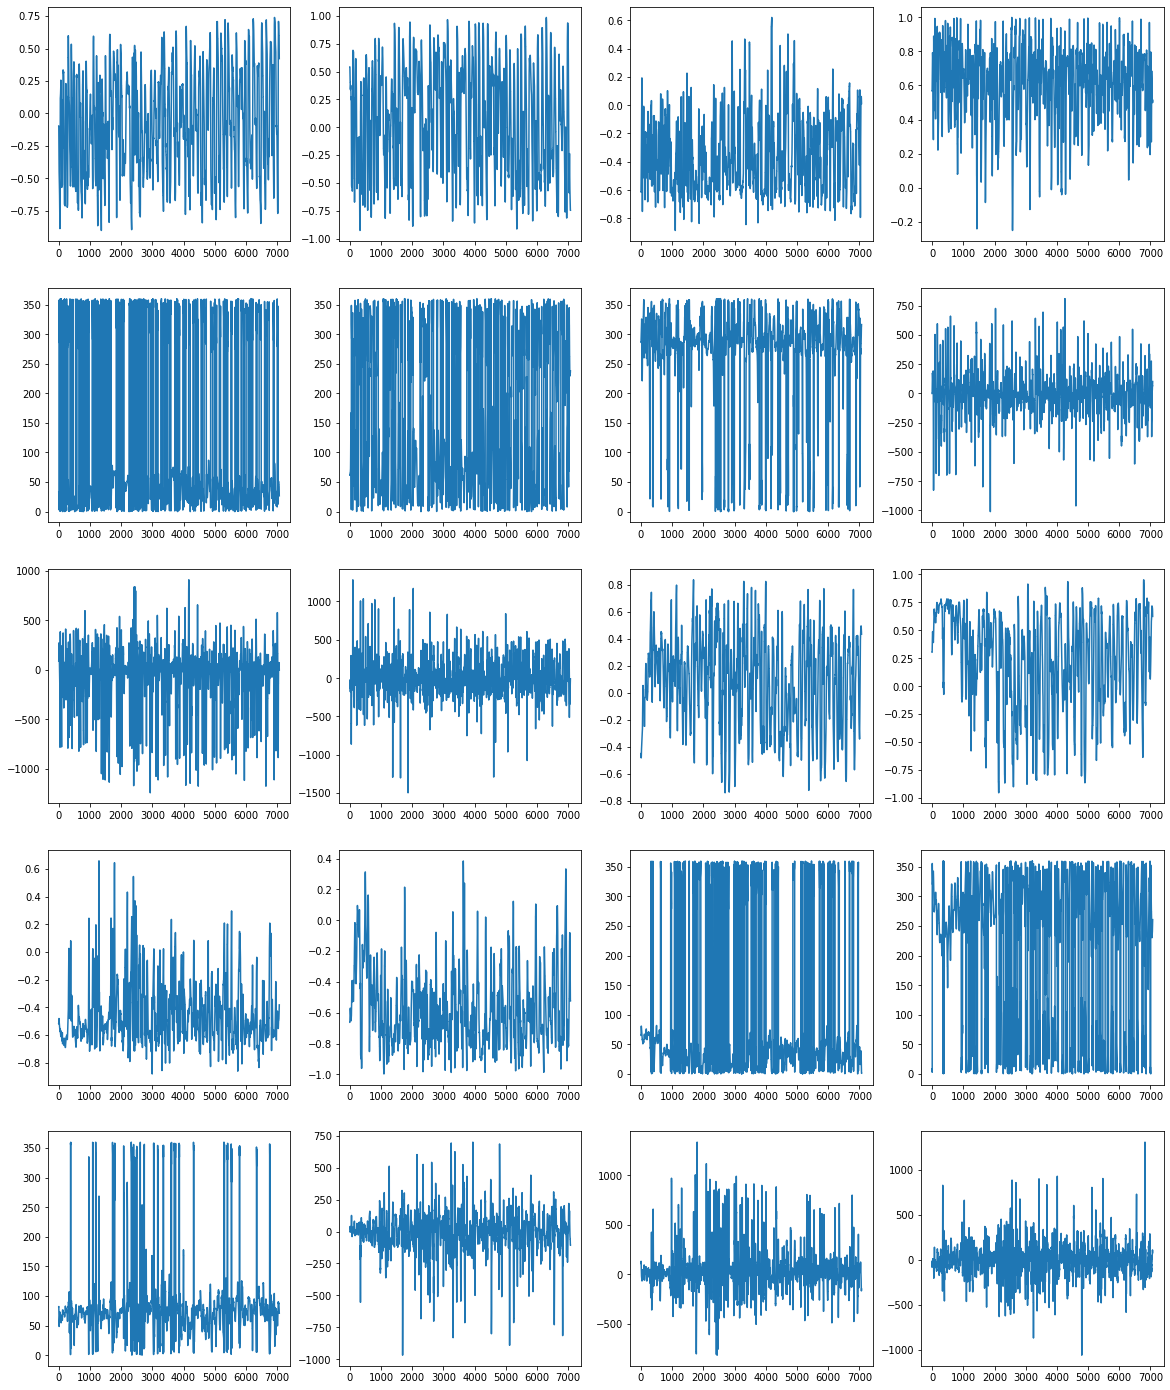

In [8]:
fig = plt.figure(figsize=(20,25))
gs = grid.GridSpec(5,4)

for i in range(5):
    for j in range(4):
        idx = j+i*4
        ax = plt.subplot(gs[i,j])

        ax.plot(data[:,idx])

### Filtering the data by train, test, val (will be used later in the generator)

In [9]:
all_filenames = os.listdir(path)

# Using 3 classes:
classes = ["Crouching", "Running", "Swing"]

# filter only filenames for the used classes:
used_filenames = []
for filename in all_filenames:
  for class_n in classes:
    if class_n in filename:
      used_filenames.append(filename)
      
test_filenames = [x for x in used_filenames if ("Actor0" in x or "Actor1" in x)]
val_filenames = [x for x in used_filenames if ("Actor2" in x)]
# get remaining files for training
train_filenames = list(set(used_filenames) - set(test_filenames) - set(val_filenames))


In [10]:
print(f"test filenames (first 5 out of {len(test_filenames)}):", test_filenames[:5])
print("val filenames", val_filenames)
print(f"train filenames (first 5 out of {len(train_filenames)}):", train_filenames[:5])

test filenames (first 5 out of 9): ['Actor10Swing.txt', 'Actor1Running.txt', 'Actor10Crouching.txt', 'Actor1Swing.txt', 'Actor1Crouching.txt']
val filenames ['Actor2Crouching.txt', 'Actor2Swing.txt', 'Actor2Running.txt']
train filenames (first 5 out of 21): ['Actor9Crouching.txt', 'Actor7Running.txt', 'Actor5Crouching.txt', 'Actor6Swing.txt', 'Actor3Crouching.txt']


# Task

Papers: 

- [Review on LSTMS/GRU's](https://asset-pdf.scinapse.io/prod/2944851425/2944851425.pdf)

- [PeekDB](https://www.scitepress.org/Papers/2018/65852/65852.pdf)

## 1) Data pipeline

Get the data from https://github.com/RafaelDrumond/PeekDB

Normalize the data and write a data generator which outputs data pairs of shape x=(Batchsize,60,20), y=(Batchsize,1). The generator should have an argument "mode" which specifies whether we want train/test. Use Actor 0 and 1 for testing, 2 for val, and actor 3 and onwards for training. Limit the experiment to classes "Crouching", "Running", "Swing".

## 2.1) RNN Modeling
Build a LSTM/GRU architecture to succesfully classify this dataset.
Run for 25 epochs and report your results.
Classes used:  "Crouching", "Running", "Swing"

Use Actor 2 for validation, and actor 3 and onwards for training. Use early stopping on the validation data and report the test performance.

## 2.1) Window size
Add a parameter controlling the window size to your data generator and analyze the influence of varying the window size has on your model and the corresponding performance.

## 3) Data augmentation
Add data augmentation to your pipeline or any useful preprocessing you want to experiment with.

## Task 1 - Data pipeline

### Implementing the encoder and decoder for encoding the classes "Crouching", "Running", "Swing":

In [13]:
# encoding as one hot encoding:
def encode_classes(arr, one_hot=False):
  enc = { "Crouching":0,
         "Running": 1,
         "Swing": 2}
    
  encoded_to_nrs= [enc[x] for x in arr] #encoding strings to 0, 1, 2
  if one_hot:
    # one hot encoding the classes:
    return tf.one_hot(encoded_to_nrs, depth=3)
  else:
    return encoded_to_nrs


def decode_classes(arr_one_hot_encoded, one_hot=False):
  encoded_to_nrs = arr_one_hot_encoded

  if one_hot:
    encoded_to_nrs = [tf.argmax(x, axis=0).numpy() for x in arr_one_hot_encoded]

  dec = { 0: "Crouching",
         1: "Running",
         2: "Swing"}

  return [dec[x] for x in encoded_to_nrs]


In [14]:
import tensorflow as tf
import os
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler


class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, batch_size, mode, dataset_path, window_size=60, one_hot_encoding=False):
    self.batch_size= batch_size
    self.mode = mode
    self.dataset_path = dataset_path
    self.window_size = window_size
    self.one_hot_encoding = one_hot_encoding
    self.get_filenames()
    self.load_files_data()
    self.sample_data_windows()
    self.normalize_data(self.data_windows_all)
  
  def get_filenames(self):    
    all_filenames = os.listdir(self.dataset_path)

    # Using 3 classes:
    classes = ["Crouching", "Running", "Swing"]

    # filter only filenames for the used classes:
    used_filenames = []
    for filename in all_filenames:
      for class_n in classes:
        if class_n in filename:
          used_filenames.append(filename)
    
    if self.mode=="test":
      self.filenames = [x for x in used_filenames if ("Actor0" in x or "Actor1" in x)]
    elif self.mode=="val":
      self.filenames = [x for x in used_filenames if ("Actor2" in x)]
    else: #mode==train:
      self.filenames = [x for x in used_filenames if not("Actor0" in x or "Actor1" in x or "Actor2" in x)]

  def shuffle_data(self, X, y):
    """ shuffle X and y, and keep the same indexes"""
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

  def load_files_data(self):
    loaded_data =  []
    loaded_data_cls = []
    for filename in self.filenames:
      data, cls = self.load_data_from_file(filename)
      loaded_data.append(data)
      loaded_data_cls.append(cls)
    
    self.loaded_data = np.array(loaded_data)
    self.loaded_data_cls = np.array(encode_classes(loaded_data_cls))

    # # shuffle data:
    # self.loaded_data, self.loaded_data_cls = self.shuffle_data(self.loaded_data, self.loaded_data_cls)
    
  def load_data_from_file(self, filename):
    cl = ''.join([i for i in filename.split(".")[0] if not i.isdigit()])
    cl = cl[5:]

    file = open(os.path.join(path,filename),"r").read().split("\n")

    data = []
    for line in file:
        if len(line) == 0:
            continue

        ts = line.split("|m")[1].split("|class")[0]

        data.append([float(val) for val in ts.split(" ") if len(val)!=0])
    data = np.array(data)

    return data, cl

  # def normalize_data(self, data):
  #   return tf.keras.utils.normalize(data, axis=-1)
  
  def normalize_data(self, data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

  def sample_data_windows(self):
    """divide data into windows"""
    self.data_windows_all = []
    self.data_windows_all_cls = []

    for data, label in zip(self.loaded_data, self.loaded_data_cls):
      time_series_generator = TimeseriesGenerator(data, 
                                                      [label]*len(data), 
                                                      length=self.window_size, 
                                                      batch_size=len(data))
      
      data_windows, data_windows_cls = time_series_generator[0]
      self.data_windows_all.extend(data_windows)
      self.data_windows_all_cls.extend(data_windows_cls)
   
    self.data_windows_all = np.array( self.data_windows_all)
    self.data_windows_all_cls = np.array( self.data_windows_all_cls)
    
    # shuffle data:
    self.data_windows_all, self.data_windows_all_cls = self.shuffle_data(self.data_windows_all, self.data_windows_all_cls)
    

  def __getitem__(self, index):
    all_data = self.data_windows_all[index:index+self.batch_size]
    all_labels = self.data_windows_all_cls[index:index+self.batch_size]

    all_data = tf.convert_to_tensor(all_data, dtype="float32")
    all_labels = tf.convert_to_tensor(all_labels, dtype="float32")

    return all_data, all_labels

    
  def __len__(self):
    """ returns nr of batches in the sequence"""
    return len(self.data_windows_all) // self.batch_size

In [18]:
batch_size=32
data_gen = DataGenerator(batch_size,"train", path)
val_gen = DataGenerator(batch_size,"val", path)
test_gen = DataGenerator(batch_size,"test", path)

# data_gen.filenames

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
# data, cl = data_gen.load_data_from_file('Actor5Running.txt')

In [20]:
# checking the shapes of the generated data:
data_batch, labels = data_gen.__getitem__(20)
data_batch.shape, labels.shape

(TensorShape([32, 60, 20]), TensorShape([32]))

## Task 2 - RNN Modeling

In [21]:
model = tf.keras.models.Sequential(
        [
            tf.keras.layers.GRU(90, input_shape=(60, 20), return_sequences=True),
            tf.keras.layers.GRU(60, return_sequences=True),
            tf.keras.layers.GRU(30, return_sequences=True),
            tf.keras.layers.GRU(30),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(3),
        ])

In [22]:
#for labels encoded as integers:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # optimizer="sgd",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 90)            30240     
                                                                 
 gru_1 (GRU)                 (None, 60, 60)            27360     
                                                                 
 gru_2 (GRU)                 (None, 60, 30)            8280      
                                                                 
 gru_3 (GRU)                 (None, 30)                5580      
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 93        
                                                        

In [23]:
num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=3,
                                                    mode='max')

history = model.fit(data_gen,                    
          validation_data=val_gen,
          epochs=num_epochs,
          callbacks=[early_stopping])

Epoch 1/10
4649/4649 [==============================] - 87s 16ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0192 - val_accuracy: 0.9909
Epoch 2/10
4649/4649 [==============================] - 69s 15ms/step - loss: 1.8711e-05 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 0.9909
Epoch 3/10
4649/4649 [==============================] - 69s 15ms/step - loss: 1.6053e-06 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 0.9924
Epoch 4/10
4649/4649 [==============================] - 73s 16ms/step - loss: 1.3986e-07 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9924
Epoch 5/10
4649/4649 [==============================] - 82s 18ms/step - loss: 1.2809e-08 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9924
Epoch 6/10
4649/4649 [==============================] - 76s 16ms/step - loss: 1.6892e-09 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9940
Epoch 7/10
4649/4649 [==============================] - 67s 14ms/step - loss: 4.1508e-10 - accuracy: 1.0

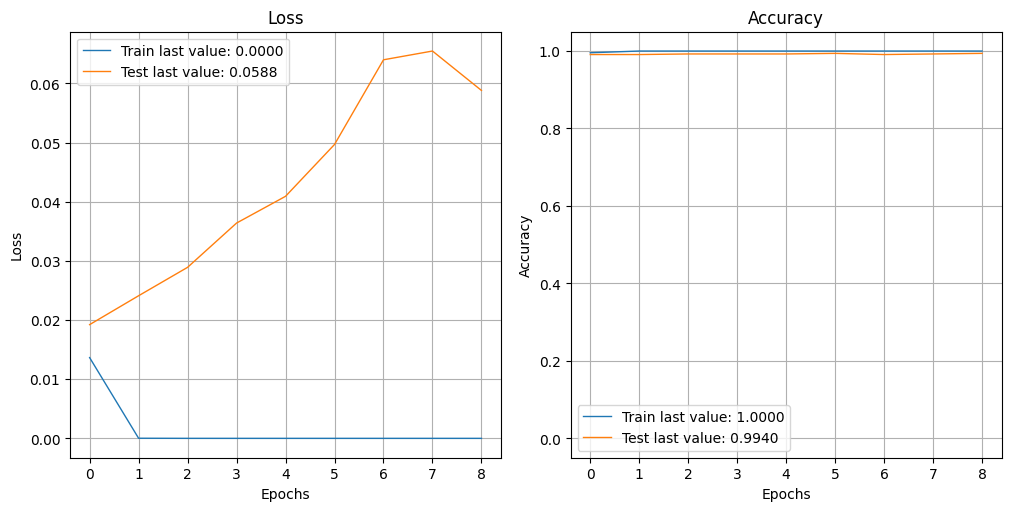

In [24]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)

### Predictions on the test set:

In [25]:
preds = model.predict_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [26]:
scores = model.evaluate(test_gen)
print("%s%s on the test set: %.2f%%" % ("Evaluating ",model.metrics_names[1], scores[1]*100))


1993/1993 [==============================] - 15s 8ms/step - loss: 0.7172 - accuracy: 0.9582
Evaluating accuracy on the test set: 95.82%


### Task 2.2 - Window size

#### Experimenting with a larger window size (80):

In [13]:
batch_size=32
data_gen = DataGenerator(batch_size,"train", path, window_size=80)
val_gen = DataGenerator(batch_size,"val", path, window_size=80)
test_gen = DataGenerator(batch_size,"test", path, window_size=80)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
model = tf.keras.models.Sequential(
        [
            tf.keras.layers.GRU(90, input_shape=(80, 20), return_sequences=True),
            tf.keras.layers.GRU(60, return_sequences=True),
            tf.keras.layers.GRU(30, return_sequences=True),
            tf.keras.layers.GRU(30),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(3),
        ])

In [16]:
#for labels encoded as integers:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # optimizer="sgd",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 80, 90)            30240     
                                                                 
 gru_5 (GRU)                 (None, 80, 60)            27360     
                                                                 
 gru_6 (GRU)                 (None, 80, 30)            8280      
                                                                 
 gru_7 (GRU)                 (None, 30)                5580      
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 93        
                                                      

In [17]:
num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=3,
                                                    mode='max')

history = model.fit(data_gen,                    
          validation_data=val_gen,
          epochs=num_epochs,
          callbacks=[early_stopping])

Epoch 1/10
4636/4636 [==============================] - 90s 17ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0061 - val_accuracy: 0.9985
Epoch 2/10
4636/4636 [==============================] - 89s 19ms/step - loss: 1.9457e-05 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 3/10
4636/4636 [==============================] - 86s 19ms/step - loss: 1.8810e-06 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9985
Epoch 4/10
4636/4636 [==============================] - 82s 18ms/step - loss: 1.7916e-07 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 0.9985


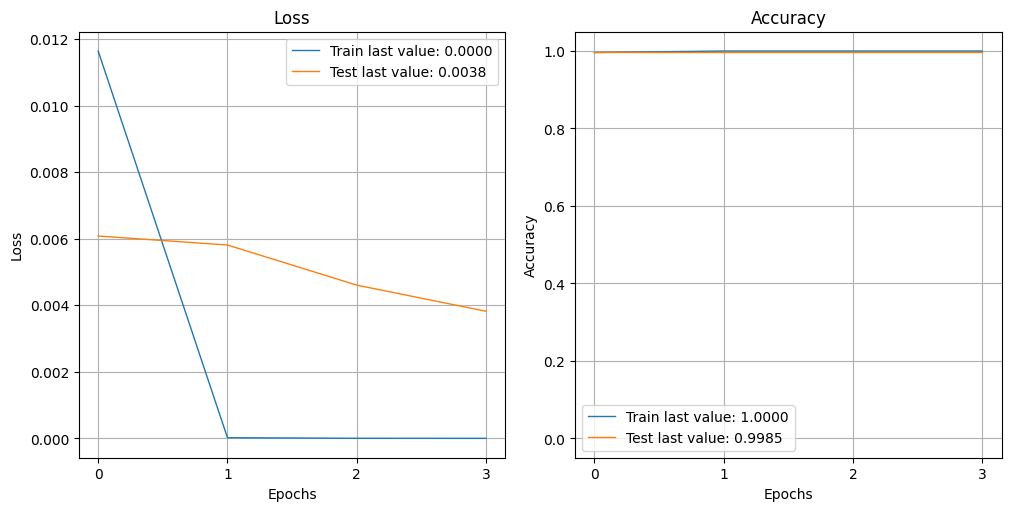

In [18]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)


In [19]:
scores = model.evaluate(test_gen)
print("%s%s on the test set: %.2f%%" % ("Evaluating ",model.metrics_names[1], scores[1]*100))

1988/1988 [==============================] - 16s 8ms/step - loss: 0.4558 - accuracy: 0.9575
Evaluating accuracy on the test set: 95.75%


#### Experimenting with a smaller window size (10):

In [48]:
batch_size=32
window_size=10
data_gen = DataGenerator(batch_size,"train", path, window_size=window_size)
val_gen = DataGenerator(batch_size,"val", path, window_size=window_size)
test_gen = DataGenerator(batch_size,"test", path, window_size=window_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [51]:
model = tf.keras.models.Sequential(
        [
            tf.keras.layers.GRU(90, input_shape=(window_size, 20), return_sequences=True),
            tf.keras.layers.GRU(60, return_sequences=True),
            tf.keras.layers.GRU(30, return_sequences=True),
            tf.keras.layers.GRU(30),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(3),
        ])

In [52]:
#for labels encoded as integers:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # optimizer="sgd",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 10, 90)            30240     
                                                                 
 gru_17 (GRU)                (None, 10, 60)            27360     
                                                                 
 gru_18 (GRU)                (None, 10, 30)            8280      
                                                                 
 gru_19 (GRU)                (None, 30)                5580      
                                                                 
 batch_normalization_4 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 3)                 93        
                                                      

In [53]:
num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=3,
                                                    mode='max')

history = model.fit(data_gen,                    
          validation_data=val_gen,
          epochs=num_epochs,
          callbacks=[early_stopping])

Epoch 1/10
4682/4682 [==============================] - 55s 11ms/step - loss: 0.0713 - accuracy: 0.9755 - val_loss: 0.1752 - val_accuracy: 0.9572
Epoch 2/10
4682/4682 [==============================] - 50s 11ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.1791 - val_accuracy: 0.9638
Epoch 3/10
4682/4682 [==============================] - 47s 10ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.1972 - val_accuracy: 0.9653
Epoch 4/10
4682/4682 [==============================] - 47s 10ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.2240 - val_accuracy: 0.9578
Epoch 5/10
4682/4682 [==============================] - 43s 9ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.1482 - val_accuracy: 0.9713
Epoch 6/10
4682/4682 [==============================] - 44s 9ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.2603 - val_accuracy: 0.9623
Epoch 7/10
4682/4682 [==============================] - 43s 9ms/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.2697 - va

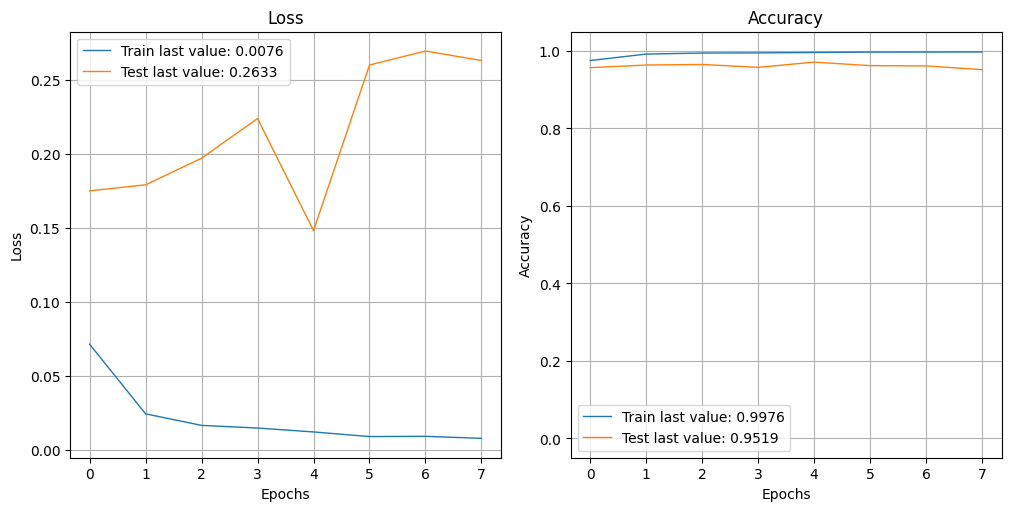

In [54]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)


In [55]:
scores = model.evaluate(test_gen)
print("%s%s on the test set: %.2f%%" % ("Evaluating ",model.metrics_names[1], scores[1]*100))

2007/2007 [==============================] - 13s 6ms/step - loss: 0.6362 - accuracy: 0.8870
Evaluating accuracy on the test set: 88.70%


With a smaller window size (10), the test accuracy is lower than with window size of 60 or 80

## Task 3 - Data augmentation

The first data augmentation technique implemented for time series is Jittering. It consists of adding random noise to the signal, to model the noise of the sensor.

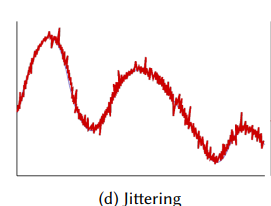

source of the image: "Data Augmentation techniques in time series domain: A survey and taxonomy" by TALAVERA et al [https://arxiv.org/pdf/2206.13508.pdf]

The second augmentation technique is scaling. It involves changing the magnitude of the data in a window by multiplying by a random scalar.

The scaling value can be defined by a normal distribution with mean 1 and  variance as a hyperparameter, or defined as a list of predefined values.

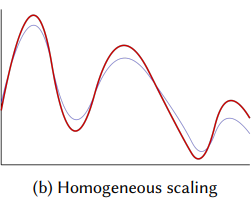

source of the image: "Data Augmentation techniques in time series domain: A survey and
taxonomy" by TALAVERA et al [https://arxiv.org/pdf/2206.13508.pdf]

In [64]:
class TimeSeriesDataAug():
  # def __init__(self):
  
  def jitter(self, data, mu=0, sigma=0.02):
    """ simulating adding sensor noise """
    return data + np.random.normal(mu, sigma, data.shape)
  
  def scaling(self, data, mu=1, sigma=0.2):
    """ changes the magnitude of the data in a window by multiplying by a random scalar , while keeping the same data shape """
    scaling_factor = np.random.normal(mu, sigma, 1)
    return data  * scaling_factor    


In [65]:
augmenter = TimeSeriesDataAug()

In [17]:
batch_size=32
window_size=60
data_gen = DataGenerator(batch_size,"train", path, window_size=window_size)
val_gen = DataGenerator(batch_size,"val", path, window_size=window_size)
test_gen = DataGenerator(batch_size,"test", path, window_size=window_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [18]:
# checking the shapes of the generated data:
data_batch, labels = test_gen.__getitem__(5)
data_batch.shape, labels.shape

(TensorShape([32, 60, 20]), TensorShape([32]))

### Visualising Jittering data augmentation:

Text(0.5, 0.98, 'Jittering data augmentation')

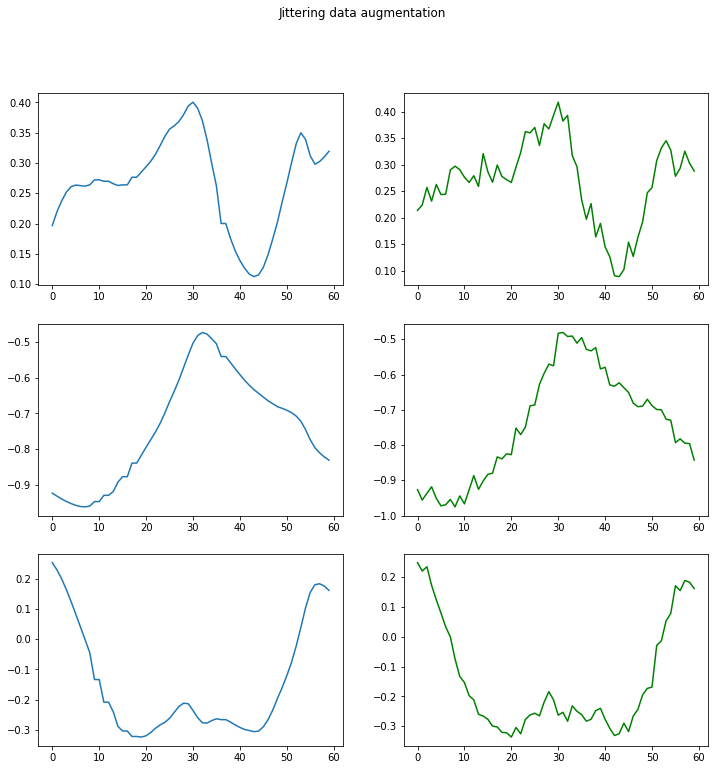

In [58]:
n_rows, n_cols = 3, 2
fig = plt.figure(figsize=(12,12))
gs = grid.GridSpec(n_rows, n_cols)

for i in range(n_rows):
    ax0 = plt.subplot(gs[i,0])
    ax1 = plt.subplot(gs[i,1])
    data_ = data_batch[0][:,i]
    ax0.plot(data_)
    ax1.plot(augmenter.jitter(data_), color="green")

plt.suptitle("Jittering data augmentation")

### Visualising Scaling data augmentation:

Text(0.5, 0.98, 'Scaling data augmentation')

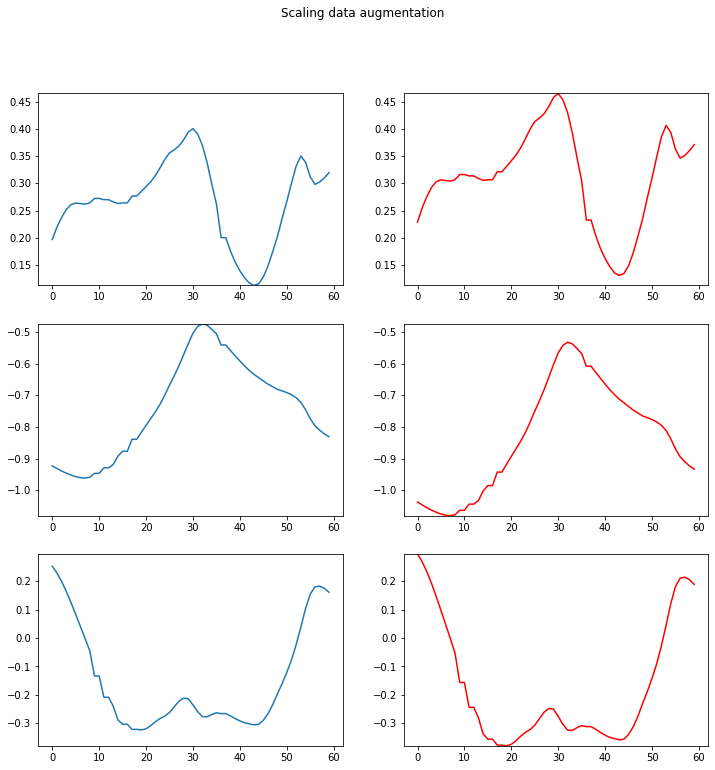

In [66]:
n_rows, n_cols = 3, 2
fig = plt.figure(figsize=(12,12))
gs = grid.GridSpec(n_rows, n_cols)

for i in range(n_rows):
    # idx = j+i*n_cols
    ax0 = plt.subplot(gs[i,0])
    ax1 = plt.subplot(gs[i,1])
    data_ = data_batch[0][:,i]
    ax0.plot(data_)
    scaled_data = augmenter.scaling(data_)
    ax1.plot(scaled_data, color="red")

    y_min = min([min(scaled_data), min(data_)])
    y_max = max([max(scaled_data), max(data_)])
    # set the same y scale on both plots:
    ax0.set_ylim([y_min, y_max])
    ax1.set_ylim([y_min, y_max])

plt.suptitle("Scaling data augmentation")

### Training the model again with data augmentation (window size 60):

In [91]:
# creating a custom keras augmentation layer:
class AugmentLayer(tf.keras.layers.Layer):
  def __init__(self, use_aug=["jitter", "scaling"]):
    super(AugmentLayer, self).__init__()
    self.augmenter = TimeSeriesDataAug()
    self.use_aug = use_aug

  def call(self, inputs):
    if "jitter" in self.use_aug:
      inputs = self.augmenter.jitter(inputs)
    if "scaling" in self.use_aug:
      inputs = self.augmenter.scaling(inputs)

    return inputs

      

In [92]:
model = tf.keras.models.Sequential(
        [
            AugmentLayer(use_aug=["jitter", "scaling"]), #adding the augmentation layer
            tf.keras.layers.GRU(90, input_shape=(window_size, 20), return_sequences=True),
            tf.keras.layers.GRU(60, return_sequences=True),
            tf.keras.layers.GRU(30, return_sequences=True),
            tf.keras.layers.GRU(30),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(3),
        ])

In [93]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

In [94]:
num_epochs = 10

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    patience=3,
                                                    mode='max')

history = model.fit(data_gen,                    
          validation_data=val_gen,
          epochs=num_epochs,
          callbacks=[early_stopping])

Epoch 1/10
4649/4649 [==============================] - 74s 15ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0095 - val_accuracy: 0.9942
Epoch 2/10
4649/4649 [==============================] - 67s 14ms/step - loss: 1.4319e-05 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9942
Epoch 3/10
4649/4649 [==============================] - 63s 14ms/step - loss: 1.4101e-06 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9927
Epoch 4/10
4649/4649 [==============================] - 67s 14ms/step - loss: 1.2434e-07 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 0.9927


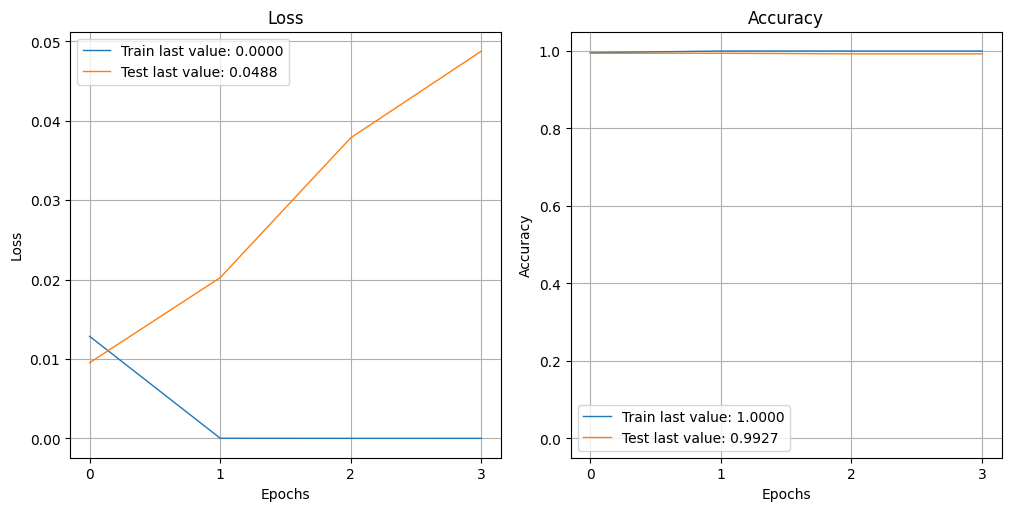

In [95]:
from plot_keras_history import show_history, plot_history

show_history(history)

In [96]:
scores = model.evaluate(test_gen)
print("%s%s on the test set: %.2f%%" % ("Evaluating ",model.metrics_names[1], scores[1]*100))

1993/1993 [==============================] - 14s 7ms/step - loss: 0.4610 - accuracy: 0.9660
Evaluating accuracy on the test set: 96.60%


It can be observed that by adding data augmentation, the model is able to achieve the highest accuracy (**96.60%** vs 95.82% for window size 60, 95.75% for window size 80 and 88.70% for window size 10)

### References

- *Data Augmentation techniques in time series domain: A survey and
taxonomy* by Talavera et al (https://arxiv.org/pdf/2206.13508.pdf)

- *Data Augmentation of Wearable Sensor Data for Parkinson’s Disease Monitoring using Convolutional Neural Networks* by Um et al (https://arxiv.org/pdf/1706.00527.pdf)

- https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

- https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/